# Mount Drive

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# imports


In [38]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import tensorflow.keras
from tensorflow.keras import models, layers, optimizers

from	tensorflow.keras.models import	Sequential
from	tensorflow.keras.layers import	Dense,	Activation
from scipy.stats import zscore

# Print Config


In [39]:
#comment to turn off, prints more data.
def show_allData(all):
  if all:
    np.set_printoptions(threshold=np.inf) #numpy show whole array
    pd.set_option('display.max_rows', None) #pandas show whole dataframe
  else:
    np.set_printoptions(threshold=6) #numpy show whole array
    pd.set_option('display.max_rows', 6)




# Read CSV

In [40]:
import pandas as pd
toRead='/content/drive/Shareddrives/Team 8- Neural Network/Assignment-7/Credit_Approval.csv'
df = pd.read_csv(toRead, header=0)
#df.head()

## Parse Data


In [41]:
def calc_smooth_mean(df, by, on, m):
    """
    Calculates a mean to create a encode
    """
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [42]:
#set a16 into numbers, rather than symbols
YTitle='a16'
scale_mapper={'+':1,'-':0}
df[YTitle].replace(scale_mapper,inplace=True)

In [43]:
XCol_isString={'s3':False, 'a8':False, 'a9':True, 'a10':True, 'a11':True, 'a12':True, 'a15':False}
#cols = df.select_dtypes(include=['object']) #^better way of doing this


#creating encoding with smooth mean
for key, value in XCol_isString.items():
  if value:
    df[key] = calc_smooth_mean(df, by=key, on=YTitle, m=10)

  df[key]= zscore(df[key])        # normalizing

df[XCol_isString]


,s3,a8,a9,a10,a11,a12,a15
0,-0.956613,-0.291083,0.954650,1.157144,0.462147,-0.919195,-0.195413
1,-0.060051,0.244190,0.954650,1.157144,1.806902,-0.919195,-0.087852
2,-0.856102,-0.216324,0.954650,-0.864196,-0.777764,-0.919195,-0.037144
...,...,...,...,...,...,...,...
687,1.757198,-0.066806,-1.047504,1.157144,0.462147,1.087908,-0.195221
688,-0.915403,-0.652915,-1.047504,-0.864196,-0.777764,-0.919195,-0.051358
689,-0.278161,1.814125,-1.047504,-0.864196,-0.777764,1.087908,-0.195413


In [60]:
num_col=len(df.columns)
num_row=len(df)
num_feat=num_col-1



y=df[YTitle].values  

df_x=df[list(XCol_isString.keys())]

X = df_x.iloc[:num_row, :num_feat].values.astype(float) 

# Data Parsing Model -
# for missing column


In [45]:
#A class that parses data for a column that has missing data
class Parse_Miss_Col():
  def __init__(self,col_name,df,df_x):
    """
    Inits class
    col_name:missing column name e.g "a2"
    df: dataframe of the dataset
    df_x: parsed dataframe of X values
    """
    self.colTitl= col_name
    self.df=df
    self.df_x=df_x
    self.col= df[col_name]
    self.missing_row = self.df.loc[df[self.colTitl] =='?']

  def get_missing_row(self):
    """
    gives missing rows of the col
    """
    return self.missing_row
    

  def get_nonMiss_X(self):
    """
    returns the row for X's where col is not missing
    """
    num_col=len(self.df.columns)
    num_row=len(self.df)
    self.nonMiss_X= self.df_x.drop(self.missing_row.index)
    self.nonMiss_X=  self.nonMiss_X.iloc[:num_row, :num_feat].values.astype(float) 
    return self.nonMiss_X

  def get_num_nonMiss_X(self):
    """
    returns the #number row for X's where col is not missing
    """
    return self.nonMiss_X.shape[1]

  def get_col_nonMiss(self):
    """
    returns the non missing rows for targeted col
    """
    col_nonMiss= self.col.drop(self.missing_row.index)
    col_nonMiss=col_nonMiss.iloc[:].values.astype(float)
    return col_nonMiss
  
  def get_pred_input(self):
    return df_x.loc[self.missing_row.index]



# a2 Prediction


## Parse a2 data


In [46]:
parser = Parse_Miss_Col(col_name='a2',df=df,df_x=df_x)
a2_nonMiss= parser.get_col_nonMiss()
nonMiss_X= parser.get_nonMiss_X()
num_nonMiss_X= parser.get_num_nonMiss_X()
a2_missing= parser.get_missing_row()

## Prediction Model a2

In [47]:
#	create a	NN	model
model	=	Sequential()
model.add(Dense(64,	input_dim=num_nonMiss_X,	activation='relu'))	
model.add(Dense(64,	activation='relu'))	
model.add(Dense(1))
#	compile	the	network 
model.compile(optimizer='rmsprop',	loss='mse',	metrics=['mae'])

## Train model

In [48]:
#	fit	the	network
NNhist =	model.fit(nonMiss_X,	a2_nonMiss,	epochs=200,	batch_size=16, verbose=0)

## Evaluate Training


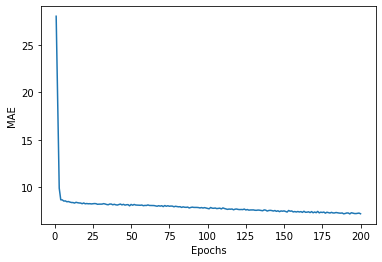

In [49]:
#	Evaluate	the	model:
import	matplotlib.pyplot as	plt
# %matplotlib inline
mae_vals =	NNhist.history['mae']
plt.plot(range(1,	len(mae_vals)	+	1),	mae_vals)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

## Predict and Fill missing a2

In [50]:
pred_X= parser.get_pred_input()       #prediction input
predictions	=	model.predict(pred_X)   #prediction values

for val, idx in zip(predictions,a2_missing.index):
  df.at[idx,'a2']=val[0]

show_allData(True)
print("After filling \n",df['a2'])
#turn off showing all
show_allData(False)

After filling 
 0        30.83
1        58.67
2        24.50
3        27.83
4        20.17
5        32.08
6        33.17
7        22.92
8        54.42
9        42.50
10       22.08
11       29.92
12       38.25
13       48.08
14       45.83
15       36.67
16       28.25
17       23.25
18       21.83
19       19.17
20       25.00
21       23.25
22       47.75
23       27.42
24       41.17
25       15.83
26       47.00
27       56.58
28       57.42
29       42.08
30       29.25
31       42.00
32       49.50
33       36.75
34       22.58
35       27.83
36       27.25
37       23.00
38       27.75
39       54.58
40       34.17
41       28.92
42       29.67
43       39.58
44       56.42
45       54.33
46       41.00
47       31.92
48       41.50
49       23.92
50       25.75
51       26.00
52       37.42
53       34.92
54       34.25
55       23.33
56       23.17
57       44.33
58       35.17
59       43.25
60       56.75
61       31.67
62       23.42
63       20.42
64       26.67
65       

# a14 Prediction

## Parse a14 data

In [51]:
parser = Parse_Miss_Col(col_name='a14',df=df,df_x=df_x)
a2_nonMiss= parser.get_col_nonMiss()
nonMiss_X= parser.get_nonMiss_X()
num_nonMiss_X= parser.get_num_nonMiss_X()
a2_missing= parser.get_missing_row()

## Prediction Model a14

In [52]:
#	create	a	NN	model
model	=	Sequential()
model.add(Dense(64,	input_dim=num_nonMiss_X,	activation='relu'))	
model.add(Dense(64,	activation='relu'))	
model.add(Dense(1))
#	compile	the	network 
model.compile(optimizer='rmsprop',	loss='mse',	metrics=['mae'])

## Train model

In [53]:
#	fit	the	network
NNhist =	model.fit(nonMiss_X,	a2_nonMiss,	epochs=200,	batch_size=16, verbose=0)

## Evaluate Training

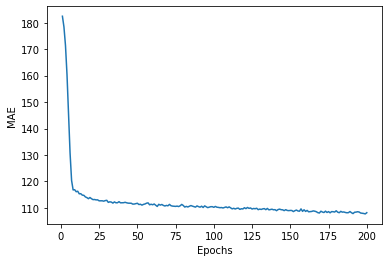

In [54]:
#	Evaluate	the	model:
import	matplotlib.pyplot as	plt
# %matplotlib inline
mae_vals =	NNhist.history['mae']
plt.plot(range(1,	len(mae_vals)	+	1),	mae_vals)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

## Predict and Fill mising a14

In [55]:
pred_X= parser.get_pred_input()       #prediction input
predictions	=	model.predict(pred_X)   #prediction values

for val, idx in zip(predictions,a2_missing.index):
  df.at[idx,'a14']=val[0]

show_allData(True)
print("After filling \n",df['a14'])
#turn off showing all
show_allData(False)

After filling 
 0        00202
1        00043
2        00280
3        00100
4        00120
5        00360
6        00164
7        00080
8        00180
9        00052
10       00128
11       00260
12       00000
13       00000
14       00000
15       00320
16       00396
17       00120
18       00000
19       00096
20       00200
21       00300
22       00000
23       00120
24       00145
25       00100
26       00000
27       00000
28       00000
29       00500
30       00168
31       00000
32       00000
33       00000
34       00000
35       00434
36       00583
37       00300
38       00260
39       00030
40       00000
41       00000
42       00240
43       00070
44       00000
45       00000
46       00455
47       00311
48       00216
49       00100
50       00491
51       00280
52       00400
53       00239
54       00000
55       00160
56       00000
57       00320
58       00711
59       00080
60       00200
61       00250
62       00080
63       00000
64       00120
65       

# Part 3- Classification

## Model 1 -Bad result

In [56]:
input_size=X.shape[1]
epochs=500

# 1. setting model
model1 = models.Sequential()
#input layer
model1.add(layers.Dense(input_size, input_dim=input_size, use_bias = False)) 
#hidden layer
model1.add(layers.Dense(input_size*2, use_bias=False, activation='relu')) 
#output layer
model1.add(layers.Dense(1, use_bias = True))

#	2.	compile	the	network and	print	a	summary
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse','accuracy'])

#	3.	fit	the	network
history1 = model1.fit(X, y, verbose = 0, epochs = epochs,batch_size=32,shuffle=False)

Model 1: 
Loss:Categorical_Crossentropy, Active=Relu, Adam
Average accuracy over the last 10 epochs:0.5347825884819031
Mean Squared Errors:


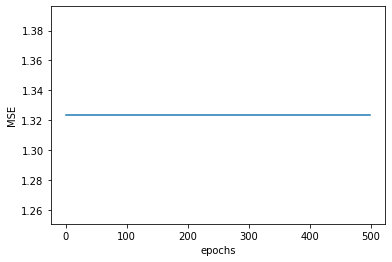

Accuracy:


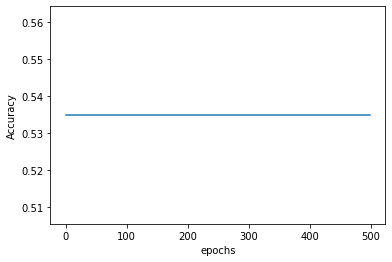

In [57]:
print('\033[1m'+'\033[4m'+"Model 1: \nLoss:Categorical_Crossentropy, Active=Relu, Adam"+'\033[0m')
last=10
AVG_ACCURACY = np.average((history1.history['accuracy'])[(epochs-last):])  #Metric for how well our architecture is equipped for this task.
print("Average accuracy over the last",last, "epochs:" +'\033[4m'+ str(AVG_ACCURACY) + '\033[0m') 

print("Mean Squared Errors:")
plt.plot(history1.history['mse'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.show()

print("Accuracy:")
plt.plot(history1.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

## Model 2


In [33]:
input_size=X.shape[1]
epochs=500

# 1. setting model
model2 = models.Sequential()
#input layer
model2.add(layers.Dense(input_size, input_dim=input_size, use_bias = False)) 
#hidden layer
model2.add(layers.Dense(input_size*2, use_bias=False, activation='tanh')) 
#output layer
model2.add(layers.Dense(1, use_bias = True))

#	2.	compile	the	network and	print	a	summary
model2.compile(optimizer='adam', loss='mse', metrics=['mse','accuracy'])

#	3.	fit	the	network
history2 = model2.fit(X, y, verbose = 0, epochs = epochs,batch_size=32,shuffle=False)

Model 2: 
Loss= MSE, Active=Tanh, Adam
Average accuracy over the last 10 epochs:0.8842029213905335
Mean Squared Errors:


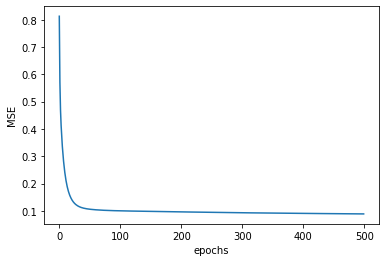

Accuracy:


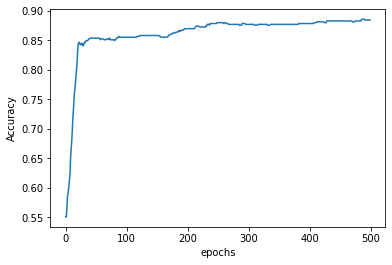

In [34]:
print('\033[1m'+'\033[4m'+"Model 2: \nLoss= MSE, Active=Tanh, Adam"+'\033[0m')
last=10
AVG_ACCURACY = np.average((history2.history['accuracy'])[(epochs-last):])  #Metric for how well our architecture is equipped for this task.
print("Average accuracy over the last",last,"epochs:" +'\033[4m'+ str(AVG_ACCURACY) + '\033[0m') 

print("Mean Squared Errors:")
plt.plot(history2.history['mse'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.show()

print("Accuracy:")
plt.plot(history2.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

## Model 3

In [35]:
epochs=500
# 1. create model
model3	=	Sequential()
model3.add(Dense(input_size,	input_dim=input_size))	
model3.add(Dense(input_size*int(input_size/2),	activation='tanh'))	
model3.add(Dense(1))
#	2.	compile	the	network
model3.compile(loss='mse',	optimizer='SGD',metrics=['mse','accuracy'])
#	3.	fit	the	network
history3= model3.fit(X,y,verbose=0,epochs=epochs)

Model 3: 
Loss= MSE, Active=Tanh, SGD
Average accuracy over the last 10 epochs:0.8675362288951873
Mean Squared Errors:


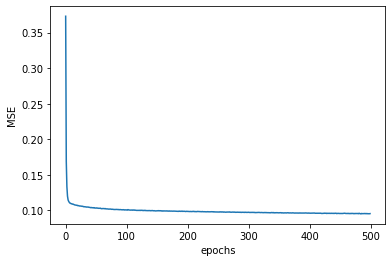

Accuracy:


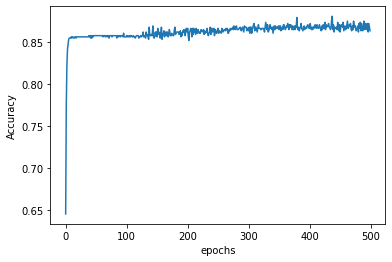

In [58]:
print('\033[1m'+'\033[4m'+"Model 3: \nLoss= MSE, Active=Tanh, SGD"+'\033[0m')
last=10
AVG_ACCURACY = np.average((history3.history['accuracy'])[(epochs-last):])  #Metric for how well our architecture is equipped for this task.
print("Average accuracy over the last", last, "epochs:" +'\033[4m'+ str(AVG_ACCURACY) + '\033[0m') 

print("Mean Squared Errors:")
plt.plot(history3.history['mse'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.show()

print("Accuracy:")
plt.plot(history3.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()